# Indentifying Stress Factors in Rainbow Trouts

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

In [2]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

SEED = 32

## Data - USDA
Performing basic cleanup and organization.
* Fishes belonging to the following categories: Control(con), Crowded(cro), High Salinity(hs), High temperature(ht), Low Temperature(lt) and Reused Water(rw).
* The dataset was transposed and renamed to become organized.
* The columns are the transcripts obtained from the fish. The prefix is the gene whereas, the suffix is the transcript number.

In [108]:
%%time
dataPath = './data/TPM_stress_USDA.xlsx'
columns = ['GeneExp']+[f"con{i}" for i in range(0,10)]+[f"cro{i}" for i in range(0, 6)]+[f"hs{i}" for i in range(0, 6)]+[f"ht{i}" for i in range(0, 6)]+[f"lt{i}" for i in range(0, 6)]+[f"rw{i}" for i in range(0, 6)]

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]

colDefMap = {'con':"Control", 'cro':"Crowded", "hs": "High Salinity", "ht": "High Temp", "lt": "Low Temp", 'rw': "Reu"}

# data = pd.read_excel(dataPath, nrows = 1000)
data = pd.read_excel(dataPath)

data.columns = columns
data = data.set_index('GeneExp').T

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]
data = data.assign(tank = tankColums)

print(data.shape)
data.head()

(40, 125909)
CPU times: user 23 s, sys: 256 ms, total: 23.3 s
Wall time: 23.4 s


GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


In [4]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, con0 to rw5
Columns: 125909 entries, 4ebp2_1 to tank
dtypes: float64(125908), object(1)
memory usage: 38.4 MB


In [5]:
data.head()

GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


In [6]:
cols = data.columns.tolist()

geneCounter = {}

for gen in [i.split('_')[0] for i in cols]:
    geneCounter[gen] = geneCounter.get(gen, 0)+1
# geneCounter

print(f"There are {len(cols)} transcripts, and {len(geneCounter)} unique genes.\nThere are{len(cols)/len(geneCounter): .2f} Transcripts per gene on on average.")

There are 125909 transcripts, and 57615 unique genes.
There are 2.19 Transcripts per gene on on average.


In [7]:
print(data.shape)

(40, 125909)


Primary Data Analysis Observations:
* The distribution of rows are as such: 10 rows in Control. 6 in the remaining.
* Clearly, we have a lot of columns in comparison on the number of rows.
* The number of columns are 125908 and the number of rows are 40.
* This is a typical high dimensional p>n problem.

## Dimensionality Reduction 
* Removing columns with mean 0

In [8]:
# Removing columns with mean 0
meanZeroCols = data.iloc[:,:-1].mean() == 0

meanZeroCols = meanZeroCols[meanZeroCols==True].index.tolist()
print(f"Number of columns with just 0: {len(meanZeroCols)}\nTotal Number of columns: {data.shape[1]}")
print(f"This is {(len(meanZeroCols)/data.shape[1])*100: .2f}% of all columns")
# data[meanZeroCols].mean()

Number of columns with just 0: 30013
Total Number of columns: 125909
This is  23.84% of all columns


In [9]:
data = data.loc[:, (data!=0).any(axis=0)]
data.head()

GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_6,aakb1_7,aakb1_8,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.000000,0.0,5.631537,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.000000,0.0,6.048805,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,4.817612,0.0,7.248526,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.000000,0.0,7.837344,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.000000,0.0,5.786782,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


In [10]:
# kpca = KernelPCA(kernel='linear')
pca = PCA()

In [11]:
%%time
pcaData = data.iloc[:, :-1]
pca.fit(pcaData)

CPU times: user 2.29 s, sys: 217 ms, total: 2.51 s
Wall time: 479 ms


PCA()

In [12]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

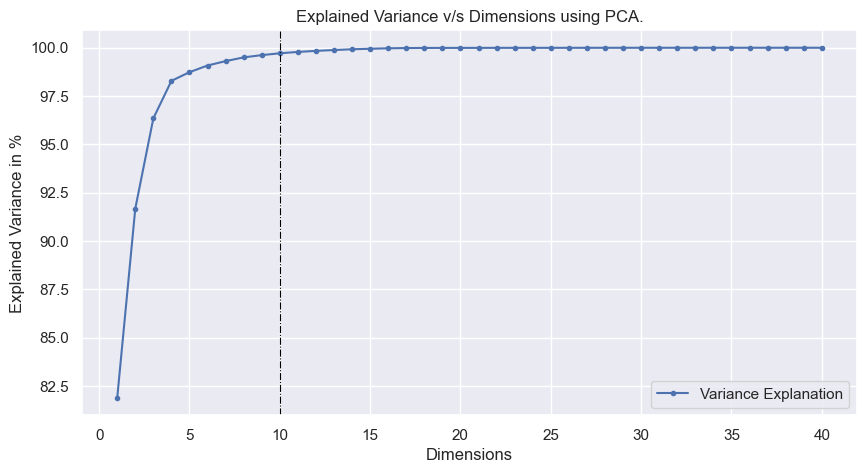

In [13]:
plt.figure(figsize=(10,5), dpi = 100)
plt.plot(range(1, len(cumsum)+1),cumsum*100,'.-', label='Variance Explanation')
plt.legend()
plt.axvline(10, ls='-.', c='black', lw=0.8)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance in %")
plt.title("Explained Variance v/s Dimensions using PCA.")
plt.show()

What the above plot is saying that, statistically, the entire dataset with 125908 columns, can be represented in the form of around 10 dimensions.

## Exploratory Data Analysis

In [14]:
data.groupby('tank').sum()#.plot()

GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_6,aakb1_7,aakb1_8,...,zwilch_1,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3
tank,,,,,,,,,,,,,,,,,,,,,
con,242.373432,336.559280,28.078077,22.697418,10.764145,30.569819,483.181415,8.845572,0.000000,52.860393,...,0.000000,4.874443,4.431331,4.605613,174.784106,77.099398,183.443888,9.157897,9.235417,9.037803
cro,164.556883,160.440878,17.679199,17.050463,7.105580,18.943720,311.843118,0.000000,0.000000,39.656491,...,0.000000,2.671778,3.563159,3.857359,107.300893,40.665702,99.988293,4.843522,4.810430,5.061424
hs,23.639558,57.961725,2.448351,1.304311,1.136457,2.495911,39.851309,0.678986,0.009943,5.451092,...,0.000000,0.358625,0.514305,0.522865,13.558132,8.255980,15.691567,1.173979,1.176177,1.178490
ht,124.767550,210.558756,13.949381,7.825844,4.712404,18.549925,246.768281,12.987430,0.309918,25.682433,...,0.005296,1.812479,2.016376,1.723104,87.021717,61.775730,142.651117,6.309693,6.539187,6.528933
lt,158.386886,171.564422,19.254322,13.900509,9.778003,17.899788,312.819083,16.642308,0.158853,19.958375,...,0.000000,3.849873,3.087986,3.159195,101.663390,37.339355,86.270179,4.406879,4.648242,4.662207
rw,153.089798,210.944561,13.079132,13.635740,6.596914,17.518561,284.277129,14.794088,0.206478,16.949882,...,0.000000,2.190003,3.116978,3.299554,112.278281,40.915950,82.027141,4.662268,4.521860,4.613485


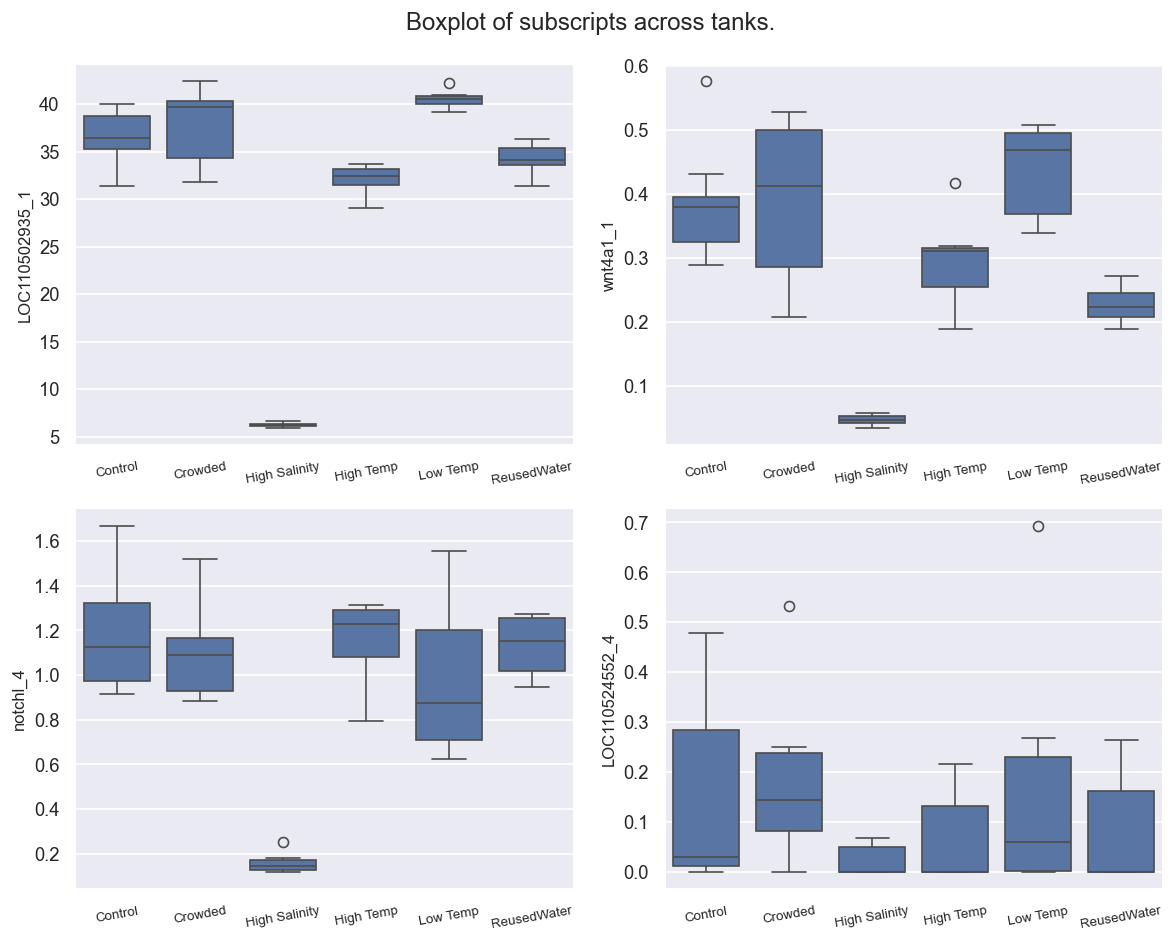

In [15]:
# plt.figure(figsize=(10,6), dpi=100)

nrows, ncols = 2,2
boxplotCols = np.random.choice(data.columns, size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8), dpi = 120, squeeze=True)

fig.suptitle("Boxplot of subscripts across tanks.")
for r in range(nrows):
    for c in range(ncols):
        idxName = boxplotCols[r][c]
        tempData = data.loc[:, ['tank', idxName]]
        sns.boxplot(data=tempData, x='tank', y=idxName, ax=ax[r][c], showfliers=True)
        # sns.boxplot(data=tempData, hue='tank', y=idxName, ax=ax[r][c], palette='rocket')
        ax[r][c].set_ylabel(idxName, fontsize=10)
        ax[r][c].set_xlabel(None, fontsize=10)
        ax[r][c].set_xticks(range(6), labels=['Control', 'Crowded', 'High Salinity', 'High Temp', 'Low Temp', 'ReusedWater'],fontsize=8, rotation=10)
        # ax[r][c].set_xticklabels(rotation=20) 

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

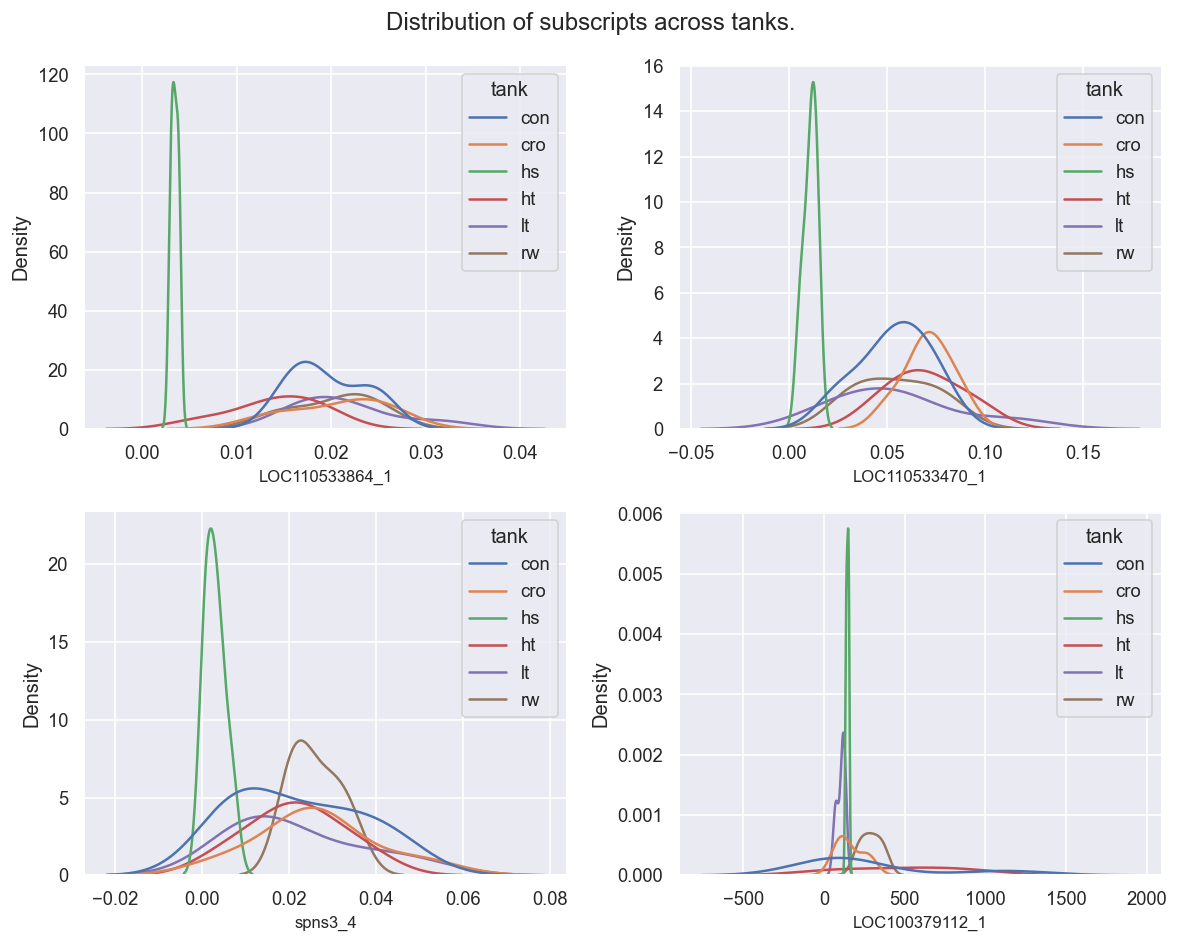

In [16]:
plt.figure(figsize=(10,6), dpi=100)

nrows, ncols = 2,2
boxplotCols = np.random.choice(data.columns, size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8), dpi = 120, squeeze=True)

fig.suptitle("Distribution of subscripts across tanks.")
for r in range(nrows):
    for c in range(ncols):
        idxName = boxplotCols[r][c]
        tempData = data.loc[:, ['tank', idxName]]
        sns.kdeplot(data=tempData,x=idxName, hue='tank', ax=ax[r][c])
        # sns.boxplot(data=tempData, hue='tank', y=idxName, ax=ax[r][c], palette='rocket')
        # ax[r][c].set_ylabel(idxName, fontsize=10)
        ax[r][c].set_xlabel(idxName, fontsize=10)
        # ax[r][c].set_xticks(range(6), labels=['Control', 'Crowded', 'High Salinity', 'High Temp', 'Low Temp', 'ReusedWater'],fontsize=8, rotation=10)
        # ax[r][c].set_xticklabels(rotation=20) 

plt.tight_layout()
plt.show()

In [17]:
# This shows that we have a certain columns with several outliers.
def findOutliersFnx(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return len(s[s<m])

In [18]:
%%time
colOutliersCount = data.iloc[:,:-1].apply(findOutliersFnx,m=3., axis=0)

CPU times: user 10.1 s, sys: 114 ms, total: 10.2 s
Wall time: 10.2 s


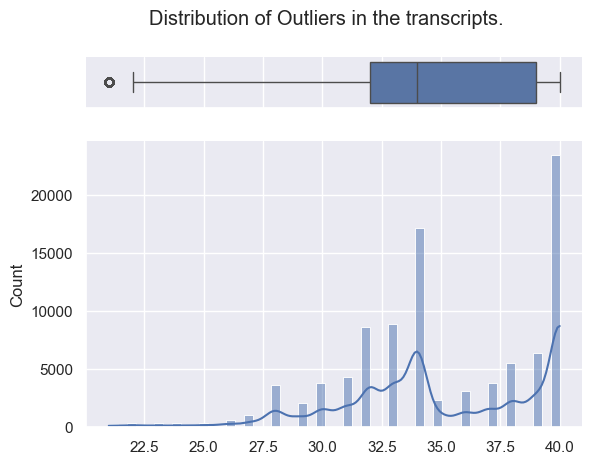

In [19]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(colOutliersCount, ax=ax_box, orient='h')
sns.histplot(colOutliersCount,bins=50, kde=True, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Distribution of Outliers in the transcripts.")
plt.show()

## Helper Function

In [20]:
def resultAnalysisFnx(ytrue,ypred,target_names=None):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names, zero_division=0))
    else:
        print(classification_report(ytrue,ypred, zero_division=0))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(6, 4))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black')

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True, zero_division=0)

## Data Creation

In [21]:
%%time
dataModel = data.copy()
dataModel.replace({'tank':{'con':0, 'cro':1, "hs": 2, "ht": 3, "lt": 4, 'rw': 5}}, inplace=True)

xdata, ydata = dataModel.iloc[:,:-1], dataModel.iloc[:,-1]

sca = MinMaxScaler()
# sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)


# xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.3, stratify=ydata, random_state=SEED)
# xtrain, xtest = np.array(xtrain), np.array(xtest)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=ydata, random_state=SEED)

<timed exec>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


CPU times: user 336 ms, sys: 8.24 ms, total: 345 ms
Wall time: 344 ms


In [22]:
print("Target Distribution in training data:")
ytrain.value_counts(normalize=True)*100

Target Distribution in training data:


tank
0    25.000000
5    17.857143
3    14.285714
2    14.285714
4    14.285714
1    14.285714
Name: proportion, dtype: float64

In [23]:
print("Target Distribution in testing data:")
ytest.value_counts(normalize=True)*100

Target Distribution in testing data:


tank
0    25.000000
2    16.666667
3    16.666667
1    16.666667
4    16.666667
5     8.333333
Name: proportion, dtype: float64

## Feature Selection Techniques

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

### ANOVA Test

In [25]:
%time
### ANOVA Test
selector = SelectKBest(f_classif, k='all')
selector.fit(xdata, ydata)

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 15 µs


SelectKBest(k='all')

In [26]:
# for feature, f_value, p_value in zip(xdata.columns, selector.scores_, selector.pvalues_):
#     print(f'Feature: {feature}, F-value: {f_value}, p-value: {p_value}')

featureScoresANOVA = pd.DataFrame({"feature":xdata.columns, "Fval":selector.scores_, "Pval":selector.pvalues_})
featureScoresANOVA.sort_values(by=['Fval','Pval'],ascending=[False,True],inplace=True)

In [27]:
featureScoresANOVA.head()

,feature,Fval,Pval
65912,LOC110532373_1,831.502309,1.651911e-34
69915,LOC110535399_1,635.580930,1.519803e-32
56092,LOC110525377_2,623.756030,2.083705e-32
1854,bckdha_1,577.057170,7.698214e-32
73595,LOC110538141_1,576.369035,7.853951e-32


In [28]:
# fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# sns.boxplot(featureScoresANOVA['Fval'], ax=ax_box, orient='h', showfliers=True)
# sns.histplot(featureScoresANOVA['Fval'],bins=50, kde=True, ax=ax_hist)
# # ax_hist.axvline(0.25,c='black',ls='-.', lw=0.7, label='Cutoff Threshold')
# # plt.legend()

# ax_box.set(yticks=[])
# sns.despine(ax=ax_hist)
# sns.despine(ax=ax_box, left=True)
# fig.suptitle("Distribution of Outliers in the transcripts.")
# plt.show()

In [30]:
featureScoresANOVA[featureScoresANOVA['Pval']<0.05]

,feature,Fval,Pval
65912,LOC110532373_1,831.502309,1.651911e-34
69915,LOC110535399_1,635.580930,1.519803e-32
56092,LOC110525377_2,623.756030,2.083705e-32
1854,bckdha_1,577.057170,7.698214e-32
73595,LOC110538141_1,576.369035,7.853951e-32
...,...,...,...
69378,LOC110535008_1,2.494139,4.996149e-02
57925,LOC110526555_2,2.494104,4.996411e-02
90368,si:ch73-265d7.2_1,2.493767,4.998891e-02
3250,celf4_22,2.493739,4.999091e-02


### Mutual Information

In [31]:
%%time
# Mutual Information
mi = mutual_info_classif(xdata, ydata)

CPU times: user 15min 17s, sys: 8min 29s, total: 23min 47s
Wall time: 3min 35s


In [32]:
featureScoresMI = pd.DataFrame({"feature":xdata.columns, "score":mi})
featureScoresMI.sort_values(by='score', ascending=False, inplace=True)

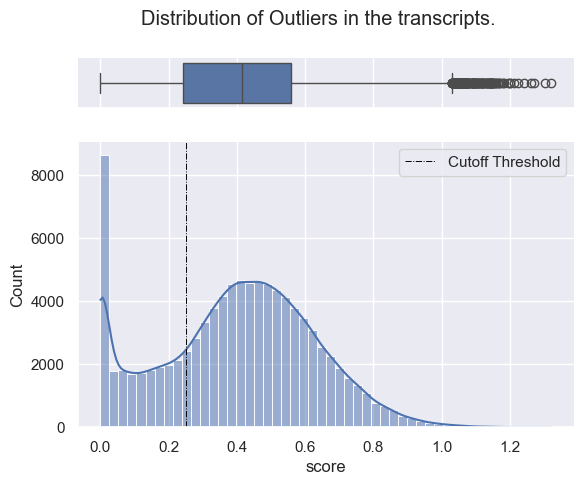

In [33]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(featureScoresMI['score'], ax=ax_box, orient='h')
sns.histplot(featureScoresMI['score'],bins=50, kde=True, ax=ax_hist)
ax_hist.axvline(0.25,c='black',ls='-.', lw=0.7, label='Cutoff Threshold')
plt.legend()

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Distribution of Outliers in the transcripts.")
plt.show()

In [34]:
featureScoresMI['score'].describe(percentiles=[.01, .05, .075, 0.25])

count    95895.000000
mean         0.398878
std          0.227619
min          0.000000
1%           0.000000
5%           0.000000
7.5%         0.004556
25%          0.243335
50%          0.415395
max          1.321464
Name: score, dtype: float64

Data shows that, about 7.5% of the columns have no contributing information to the target column whatsoever.

In [35]:
featureScoresMI[featureScoresMI.score>0.25]

,feature,score
34451,LOC110502967_1,1.321464
10203,LOC100136247_1,1.301705
4066,col10a1a_1,1.271370
38537,LOC110506123_2,1.263115
70589,LOC110535859_1,1.240515
...,...,...
80387,LOC118947070_1,0.250022
27293,LOC110497584_2,0.250015
20091,LOC110492138_3,0.250012
46502,LOC110514629_2,0.250008


### Common Features
Features common between both feature selections

In [36]:
fSelect1_ = featureScoresANOVA[featureScoresANOVA['Pval']<0.05]['feature']
fSelect2_ = featureScoresMI[featureScoresMI.score>0.25]['feature']

In [37]:
%%time
commonFeatures = list(set(fSelect1_) & set(fSelect2_))
print(f"{len(commonFeatures)*100/featureScoresMI.shape[0]:.2f}% of previous column set")

72.08% of previous column set
CPU times: user 47.7 ms, sys: 1.61 ms, total: 49.3 ms
Wall time: 16.3 ms


In [38]:
featureScoresANOVA.shape, featureScoresMI.shape

((95895, 3), (95895, 2))

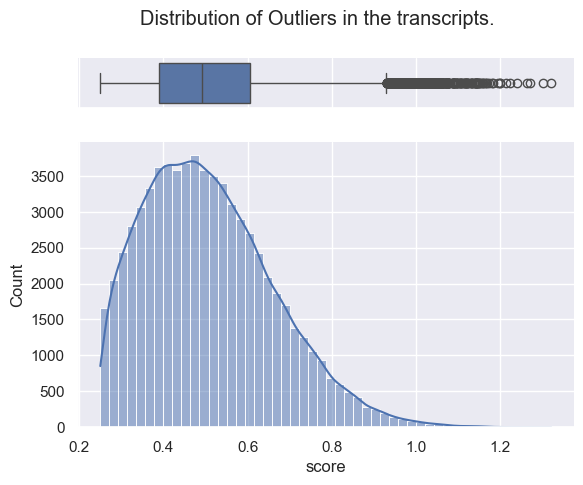

In [39]:
temp_ = featureScoresMI[featureScoresMI.feature.isin(commonFeatures)]

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(temp_['score'], ax=ax_box, orient='h')
sns.histplot(temp_['score'],bins=50, kde=True, ax=ax_hist)
# ax_hist.axvline(0.25,c='black',ls='-.', lw=0.7, label='Cutoff Threshold')
# plt.legend()

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Distribution of Outliers in the transcripts.")
plt.show()

In [40]:
len(commonFeatures)

69122

## Primary Feature Selection

In [53]:
%%time
dataModel = data.copy()
dataModel.replace({'tank':{'con':0, 'cro':1, "hs": 2, "ht": 3, "lt": 4, 'rw': 5}}, inplace=True)

xdata, ydata = dataModel.loc[:, commonFeatures], dataModel.iloc[:,-1]

sca = MinMaxScaler()
# sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)


# xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.3, stratify=ydata, random_state=SEED)
# xtrain, xtest = np.array(xtrain), np.array(xtest)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=ydata, random_state=SEED)

<timed exec>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


CPU times: user 293 ms, sys: 16.6 ms, total: 309 ms
Wall time: 307 ms


In [54]:
print(xstrain.shape, xstest.shape)

(28, 69122) (12, 69122)


## Machine Learning Analysis
Feature Importance to be identified too.

In [55]:
targetNames = ['control','crowded', 'high salinity', 'high temp', 'low temp', 'resued water']

### Multinomial Naive Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB

In [57]:
# Only MinMax scaling allowed.
MulNaiBay_clf = MultinomialNB()
MulNaiBay_clf.fit(xstrain, ytrain)

MultinomialNB()

In [60]:
%%time
ypred = MulNaiBay_clf.predict(xstest)

CPU times: user 55.3 ms, sys: 2.52 ms, total: 57.8 ms
Wall time: 16.3 ms


In [61]:
ypred
# ytest

array([2, 3, 1, 1, 5, 4, 2, 4, 1, 5, 0, 4])

               precision    recall  f1-score   support

      control       1.00      0.33      0.50         3
      crowded       0.67      1.00      0.80         2
high salinity       1.00      1.00      1.00         2
    high temp       1.00      0.50      0.67         2
     low temp       0.67      1.00      0.80         2
 resued water       0.50      1.00      0.67         1

     accuracy                           0.75        12
    macro avg       0.81      0.81      0.74        12
 weighted avg       0.85      0.75      0.72        12



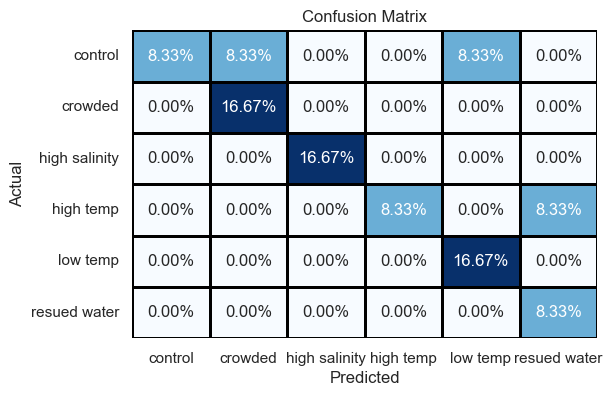

In [62]:
_ = resultAnalysisFnx(ytest, ypred, target_names=targetNames)

### Logistic Regression

In [77]:
sca = StandardScaler()
xdata_sca = sca.fit_transform(xdata)

# xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.3, stratify=ydata, random_state=SEED)
# xtrain, xtest = np.array(xtrain), np.array(xtest)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=ydata, random_state=SEED)

In [78]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrain, ytrain)

CPU times: user 1min 2s, sys: 10.5 s, total: 1min 13s
Wall time: 9.39 s


LogisticRegression(random_state=32)

In [80]:
%%time
ypred = logRes_clf.predict(xstest)

CPU times: user 36.9 ms, sys: 1.59 ms, total: 38.5 ms
Wall time: 10.9 ms


In [81]:
# ypred
# ytest

               precision    recall  f1-score   support

      control       1.00      1.00      1.00         3
      crowded       1.00      1.00      1.00         2
high salinity       1.00      1.00      1.00         2
    high temp       1.00      1.00      1.00         2
     low temp       1.00      1.00      1.00         2
 resued water       1.00      1.00      1.00         1

     accuracy                           1.00        12
    macro avg       1.00      1.00      1.00        12
 weighted avg       1.00      1.00      1.00        12



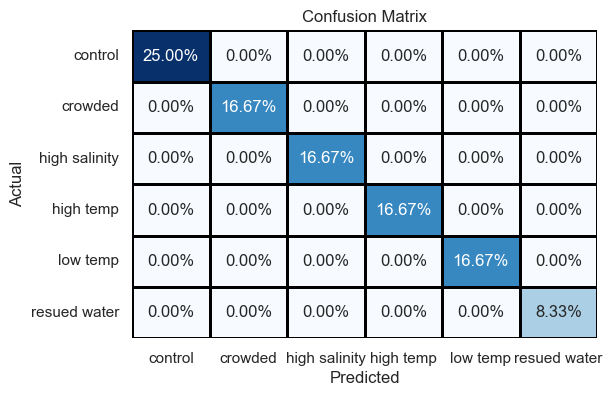

In [82]:
_ = resultAnalysisFnx(ytest, ypred, target_names=targetNames)

### Support Vector Machines

In [83]:
from sklearn.svm import SVC

In [84]:
%%time
# sca = MinMaxScaler()
sca = StandardScaler()
xdata_sca = sca.fit_transform(xdata)

# xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.3, stratify=ydata, random_state=SEED)
# xtrain, xtest = np.array(xtrain), np.array(xtest)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=ydata, random_state=SEED)

CPU times: user 280 ms, sys: 7.66 ms, total: 288 ms
Wall time: 287 ms


In [85]:
%%time
# Linear Kernel
svm_clf = SVC(kernel='linear')
svm_clf.fit(xstrain, ytrain)

ypred = svm_clf.predict(xstest)

CPU times: user 276 ms, sys: 20.3 ms, total: 297 ms
Wall time: 61.3 ms


               precision    recall  f1-score   support

      control       1.00      1.00      1.00         3
      crowded       1.00      1.00      1.00         2
high salinity       1.00      1.00      1.00         2
    high temp       1.00      1.00      1.00         2
     low temp       1.00      1.00      1.00         2
 resued water       1.00      1.00      1.00         1

     accuracy                           1.00        12
    macro avg       1.00      1.00      1.00        12
 weighted avg       1.00      1.00      1.00        12



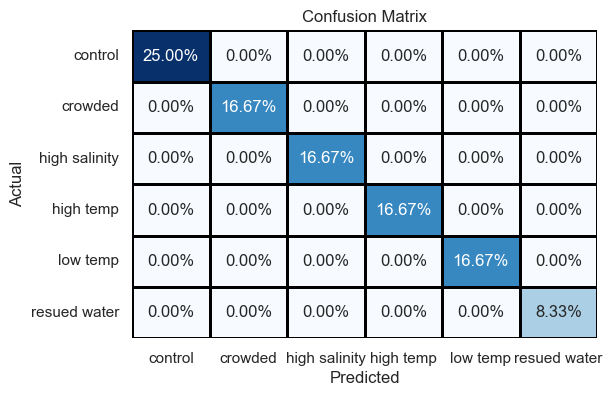

In [86]:
_ = resultAnalysisFnx(ytest, ypred, target_names=targetNames)

In [87]:
%%time
# Radial Basis Function Kernel
svm_clf = SVC(kernel='rbf')
svm_clf.fit(xstrain, ytrain)

ypred = svm_clf.predict(xstest)

CPU times: user 376 ms, sys: 12 ms, total: 388 ms
Wall time: 70.2 ms


               precision    recall  f1-score   support

      control       0.30      1.00      0.46         3
      crowded       0.00      0.00      0.00         2
high salinity       1.00      1.00      1.00         2
    high temp       0.00      0.00      0.00         2
     low temp       0.00      0.00      0.00         2
 resued water       0.00      0.00      0.00         1

     accuracy                           0.42        12
    macro avg       0.22      0.33      0.24        12
 weighted avg       0.24      0.42      0.28        12



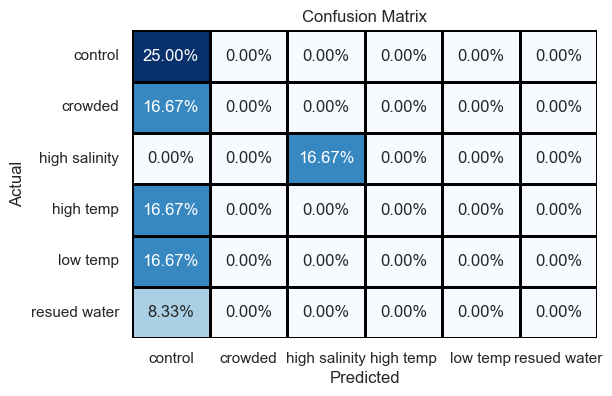

In [88]:
_ = resultAnalysisFnx(ytest, ypred, target_names=targetNames)

In [89]:
%%time
# Sigmoid Kernel
svm_clf = SVC(kernel='sigmoid')
svm_clf.fit(xstrain, ytrain)

ypred = svm_clf.predict(xstest)

CPU times: user 277 ms, sys: 16.3 ms, total: 293 ms
Wall time: 60.2 ms


               precision    recall  f1-score   support

      control       0.33      1.00      0.50         3
      crowded       0.00      0.00      0.00         2
high salinity       1.00      1.00      1.00         2
    high temp       1.00      0.50      0.67         2
     low temp       0.00      0.00      0.00         2
 resued water       0.00      0.00      0.00         1

     accuracy                           0.50        12
    macro avg       0.39      0.42      0.36        12
 weighted avg       0.42      0.50      0.40        12



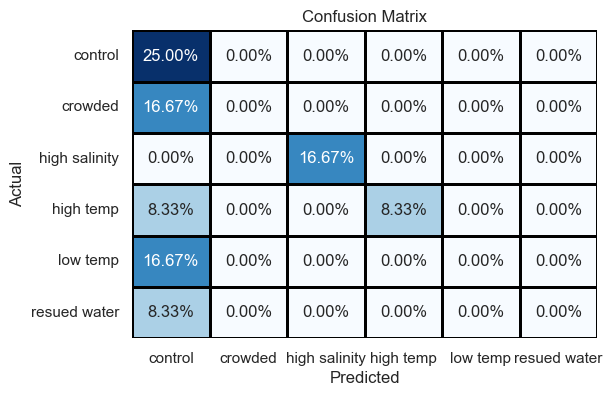

In [90]:
_ = resultAnalysisFnx(ytest, ypred, target_names=targetNames)

               precision    recall  f1-score   support

      control       0.30      1.00      0.46         3
      crowded       0.00      0.00      0.00         2
high salinity       1.00      1.00      1.00         2
    high temp       0.00      0.00      0.00         2
     low temp       0.00      0.00      0.00         2
 resued water       0.00      0.00      0.00         1

     accuracy                           0.42        12
    macro avg       0.22      0.33      0.24        12
 weighted avg       0.24      0.42      0.28        12



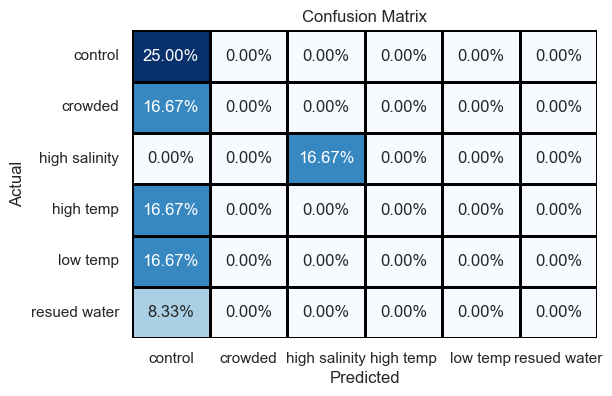

CPU times: user 1.33 s, sys: 110 ms, total: 1.44 s
Wall time: 207 ms


In [92]:
%%time
# Polynomial Kernel Degree 3
svm_clf = SVC(kernel='poly', degree=3)
svm_clf.fit(xstrain, ytrain)

ypred = svm_clf.predict(xstest)

_ = resultAnalysisFnx(ytest, ypred, target_names=targetNames)

In [93]:
%%time
acc_, f1_ = [],[]
for deg_ in range(1, 16):
    svm_clf = SVC(kernel='poly', degree=deg_)
    svm_clf.fit(xstrain, ytrain)
    
    ypred = svm_clf.predict(xstest)
    
    rep_ = classification_report(ytest,ypred,output_dict=True, zero_division=0)
    acc_.append(rep_['accuracy'])
    f1_.append(rep_['macro avg']['f1-score'])

CPU times: user 2.42 s, sys: 65.1 ms, total: 2.49 s
Wall time: 342 ms


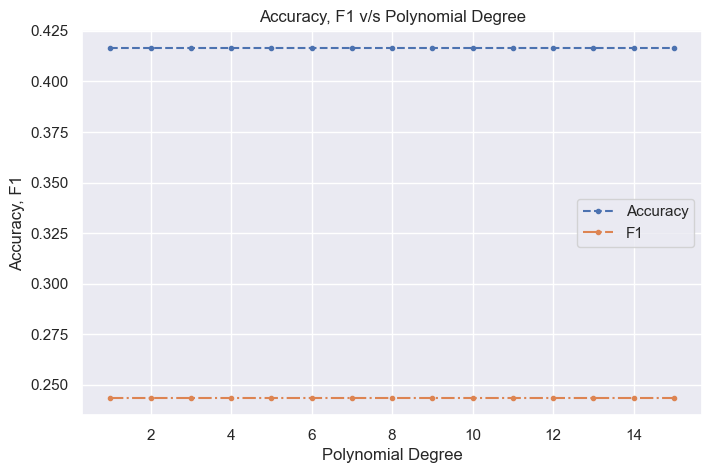

In [94]:
plt.figure(figsize=(8,5), dpi = 100)
plt.plot(range(1,16), acc_, '.--', label='Accuracy')
plt.plot(range(1,16), f1_, '.-.', label='F1')
plt.legend()
plt.title("Accuracy, F1 v/s Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy, F1")
plt.show()

Clearly, there is no change in the accuracy or f1 score with change in the degrees of freedom of the polynomial equation.

In [96]:
%%time
acc_, f1_ = [],[]
for C_ in tqdm(np.arange(0.001, 1, 0.001)):
    svm_clf = SVC(kernel='poly', degree=9, C=C_)
    svm_clf.fit(xstrain, ytrain)
    
    ypred = svm_clf.predict(xstest)
    
    rep_ = classification_report(ytest,ypred,output_dict=True, zero_division=0)
    acc_.append(rep_['accuracy'])
    f1_.append(rep_['macro avg']['f1-score'])

100%|█████████████████████████████████████████| 999/999 [00:23<00:00, 42.89it/s]

CPU times: user 2min 40s, sys: 17.7 s, total: 2min 58s
Wall time: 23.3 s


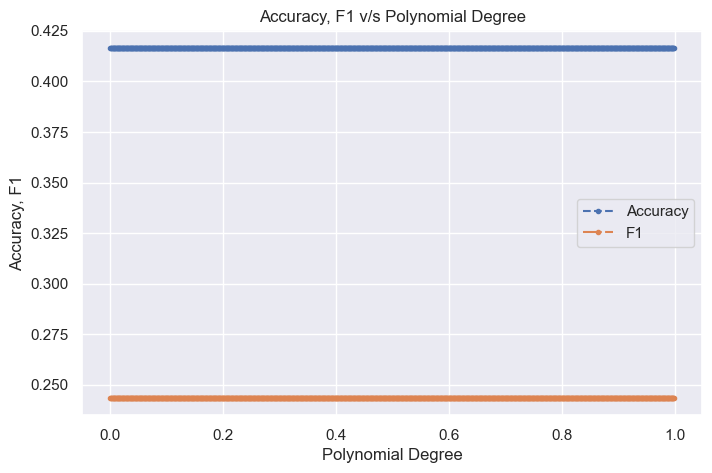

In [97]:
plt.figure(figsize=(8,5), dpi = 100)
plt.plot(np.arange(0.001, 1, 0.001), acc_, '.--', label='Accuracy')
plt.plot(np.arange(0.001, 1, 0.001), f1_, '.-.', label='F1')
plt.legend()
plt.title("Accuracy, F1 v/s Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy, F1")
plt.show()

Clearly, there is no change in the accuracy with the regularization parameter C.

### Decision Trees
* Decision Trees do not need feature scaling.

In [101]:
%%time
dataModel = data.copy()
dataModel.replace({'tank':{'con':0, 'cro':1, "hs": 2, "ht": 3, "lt": 4, 'rw': 5}}, inplace=True)

xdata, ydata = dataModel.loc[:, commonFeatures], dataModel.iloc[:,-1]

xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.3, stratify=ydata, random_state=SEED)
xtrain, xtest = np.array(xtrain), np.array(xtest)

CPU times: user 60 ms, sys: 20.4 ms, total: 80.4 ms
Wall time: 79 ms


<timed exec>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [102]:
from sklearn.tree import DecisionTreeClassifier

In [103]:
%%time
dt_clf = DecisionTreeClassifier()

dt_clf.fit(xtrain, ytrain)

ypred = dt_clf.predict(xtest)

CPU times: user 324 ms, sys: 7.22 ms, total: 331 ms
Wall time: 330 ms


               precision    recall  f1-score   support

      control       0.60      1.00      0.75         3
      crowded       0.00      0.00      0.00         2
high salinity       1.00      1.00      1.00         2
    high temp       0.50      0.50      0.50         2
     low temp       0.33      0.50      0.40         2
 resued water       0.00      0.00      0.00         1

     accuracy                           0.58        12
    macro avg       0.41      0.50      0.44        12
 weighted avg       0.46      0.58      0.50        12



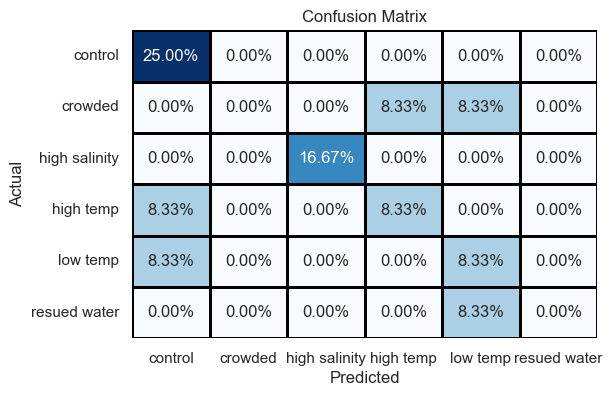

In [104]:
_ = resultAnalysisFnx(ytest, ypred, target_names=targetNames)

## Analysis Checkpoint

### Reasons Why Logistic Regression and Linear SVM Perform Better Than Decision Trees

1. **Small Dataset Size**  
   - Decision trees need more data to make reliable splits. With only 40 rows, they may struggle.  
   - Logistic regression and SVMs handle small datasets better.

2. **Linear Decision Boundaries**  
   - If the data has a linear or nearly linear structure, logistic regression and SVMs are better suited.  
   - Decision trees create non-linear splits, which might not align with the data's structure.

3. **Overfitting vs. Underfitting**  
   - Decision trees are prone to overfitting in high-dimensional data (120,000 features).  
   - Regularization in logistic regression and SVMs prevents overfitting effectively.

4. **Curse of Dimensionality**  
   - Decision trees struggle with high-dimensional data as they split features hierarchically.  
   - Logistic regression and SVMs handle high-dimensional spaces better by optimizing globally.

5. **Generalization**  
   - Logistic regression and SVMs generalize well due to their simpler structure.  
   - Decision trees may overfit or underfit depending on hyperparameter tuning.


---
## Data - UMD

In [109]:
%%time
dataPath = './data/TPM_stress_RedTrout.xlsx'

# data = pd.read_excel(dataPath, nrows = 100)
dataUMD = pd.read_excel(dataPath)

CPU times: user 41.8 s, sys: 458 ms, total: 42.3 s
Wall time: 42.9 s


In [110]:
dataUMD

,Unnamed: 0,Control,Control.1,Control.2,Control.3,Control.4,Control.5,Control.6,Control.7,Control.8,...,Heat.26,Heat.27,Heat.28,Heat.29,Heat.30,Heat.31,Heat.32,Heat.33,Heat.34,Heat.35
0,NaN,Day 7,Day 1,Day 7,Day 3,Day 1,Day 3,Day 28,Day 3,Day 28,...,Day 1,Day 1,Day 7,Day 3,Day 7,Day 1,Day 7,Day 7,Day 1,Day 1
1,4ebp2,20.392085,27.289734,24.278669,20.71429,23.821724,23.892738,21.375001,20.235502,22.33764,...,14.23274,16.493,26.194623,18.494244,24.282196,16.057303,27.09728,23.761571,15.593715,16.778716
2,5ntc,5.01189,7.310938,6.795036,10.404623,6.310578,6.614148,6.979563,6.434844,3.546688,...,2.77817,6.37417,4.629167,3.590388,3.886708,5.530786,10.646885,4.744611,2.038548,5.479155
3,aacs,2.244453,2.958239,2.367945,2.90694,2.060801,1.978058,1.616555,2.700891,1.910367,...,1.797006,2.123546,2.480115,1.558271,2.052152,1.923685,11.284582,2.090538,2.139213,7.686862
4,aadac,0.783542,1.270043,0.872521,1.307162,1.290215,1.25826,1.147624,1.26906,1.072136,...,0.460834,0.670186,0.924309,0.724395,0.597182,0.81681,11.864627,0.724528,0.676979,6.993122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125904,zyx_1,4.216087,5.1805,4.752717,7.467661,2.68104,3.714909,2.512279,2.267796,1.377651,...,3.846909,0,2.637796,1.008691,1.204568,1.222368,13.070852,2.27617,3.916161,10.430283
125905,zyx_2,0,0.843944,0,0.015257,1.912857,1.81762,3.840462,3.349152,2.825636,...,0,4.893776,1.128665,2.497711,3.226769,3.624637,0,2.312759,0.146543,0
125906,zzef1_1,1.423811,2.746311,2.029312,2.265504,1.794056,2.133849,1.968963,2.282304,2.040706,...,1.865047,2.456711,2.405025,1.80566,1.89837,2.280168,4.404682,2.372172,1.865096,3.593704
125907,zzef1_2,1.684077,2.820902,1.88996,2.312579,1.98408,2.280215,1.862148,2.185184,1.977592,...,1.924099,2.410552,2.366936,1.689027,1.908916,2.280168,5.133276,2.227527,2.040302,3.809992


In [111]:


colsTemp = ['idx']+['CTRL']*(dataUMD.shape[1]//2)+['HEAT']*(dataUMD.shape[1]//2)

dataUMD.columns = colsTemp
dataUMD.iloc[0,0] = 'DAY'

dataUMD = dataUMD.set_index("idx").T.reset_index(drop=False, names = 'GeneExp')#.set_index("DAY", append=True)

print(dataUMD.shape)

(72, 125910)


In [ ]:
dataUMD.head()

In [ ]:
dataUMD.groupby(['GeneExp','DAY']).mean()